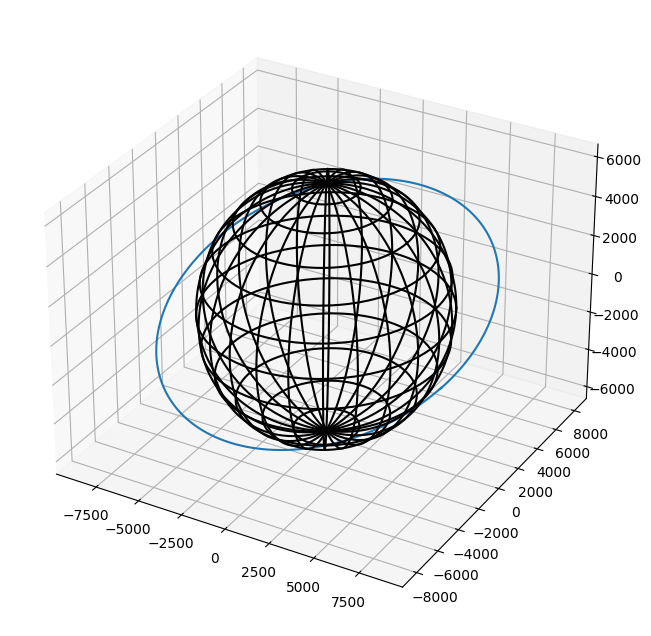

In [33]:
%run Spacecraft-Model.ipynb

In [9]:
%run ADCS-Controller.ipynb

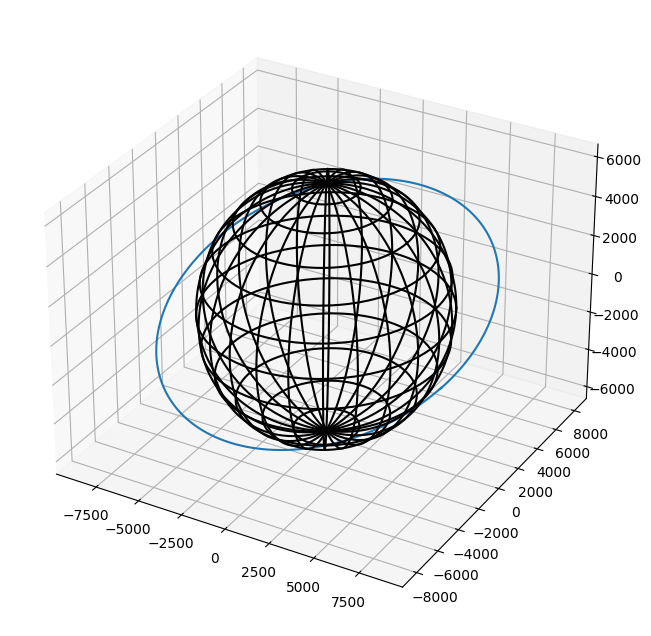

In [31]:
dt = 0.1
s1 = Spacecraft_Model(dt)
s1.graph_orbit()

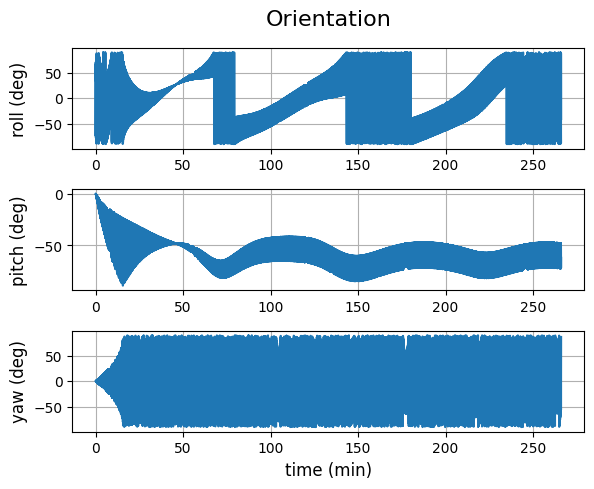

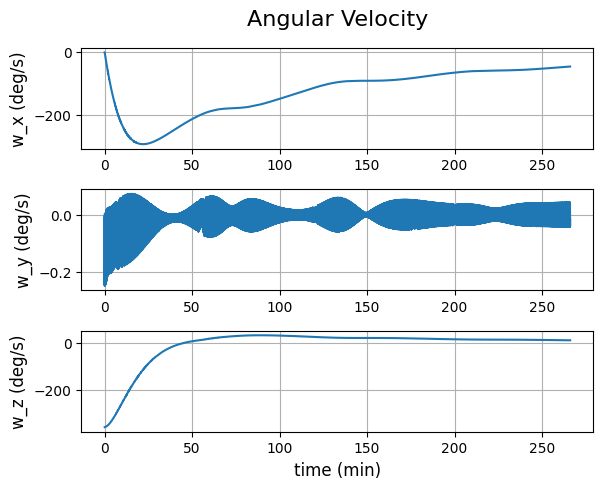

In [34]:
dt = 1
s2 = Spacecraft_Model(dt)
adcs = ADCS()
time = np.arange(0,Spacecraft_Model.orbit_len * 2,dt)

roll_history, pitch_history, yaw_history = np.zeros(len(time)), np.zeros(len(time)), np.zeros(len(time))
w_history = np.zeros((len(time), 3))


m = np.zeros(3)

for i in range(time.size):
    pos, cang, mag_field = s2.tick(m)
    
    adcs.detumble(mag_field, cang)
    m = adcs.moment

    # Calculate ideal orientation
    r = s2.get_position()
    v = s2.get_velocity()
    
    # Find the ideal orientation of the spacecraft in the ICRF
    b_x = -normalize(r)
    b_y = normalize(v)
    b_z = cross(b_x, b_y)

    # Construct the nominal DCM from inertial to body from the body axes
    # Compute the equilvalent quaternion
    dcm_target = np.stack([b_x, b_y, b_z])
    q_target = dcm_to_quaternion(dcm_target)

    # Calculate the difference between the desired orientation and the current orientation
    q_curr = s2.q_t
    q_err = quaternion_multiply(q_curr, quaternion_inverse(q_target))

    yaw_history[i] = np.arctan(2*(q_err[1]*q_err[2] + q_err[0]*q_err[3]) / (q_err[3]**2 - q_err[0]**2 - q_err[1]**2 + q_err[2]**2))
    pitch_history[i] = np.arcsin(-2*(q_err[0]*q_err[2] - q_err[1]*q_err[3]))
    roll_history[i] = np.arctan(2*(q_err[0]*q_err[1] + q_err[2]*q_err[3]) / (q_err[3]**2 + q_err[0]**2 - q_err[1]**2 - q_err[2]**2))
    
    w_history[i] = s2.w_t

time = time / 60

fig1 = plt.figure()
fig1.suptitle('Orientation', fontsize=16)

# Plot roll:
ax1 = fig1.add_subplot(3, 1, 1)
ax1.plot(time, np.rad2deg(roll_history))
ax1.set_ylabel('roll (deg)', fontsize=12)
ax1.grid(True)

# Plot pitch:
ax2 = fig1.add_subplot(3, 1, 2)
ax2.plot(time, np.rad2deg(pitch_history))
ax2.set_ylabel('pitch (deg)', fontsize=12)
ax2.grid(True)

# Plot yaw:
ax3 = fig1.add_subplot(3, 1, 3)
ax3.plot(time, np.rad2deg(yaw_history))
ax3.set_ylabel('yaw (deg)', fontsize=12)
ax3.set_xlabel('time (min)', fontsize=12)
ax3.grid(True)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

fig2 = plt.figure()
fig2.suptitle('Angular Velocity', fontsize=16)

# Plot rolling:
ax1 = fig2.add_subplot(3, 1, 1)
ax1.plot(time, np.rad2deg(w_history[:, 0]))
ax1.set_ylabel('w_x (deg/s)', fontsize=12)
ax1.grid(True)

# Plot pitching:
ax2 = fig2.add_subplot(3, 1, 2)
ax2.plot(time, np.rad2deg(w_history[:, 1]))
ax2.set_ylabel('w_y (deg/s)', fontsize=12)
ax2.grid(True)

# Plot yawing:
ax3 = fig2.add_subplot(3, 1, 3)
ax3.plot(time, np.rad2deg(w_history[:, 2]))
ax3.set_ylabel('w_z (deg/s)', fontsize=12)
ax3.set_xlabel('time (min)', fontsize=12)
ax3.grid(True)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.show()